In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Загрузка данных
file_path = "C:/Users/daure/Desktop/CyberThreat/cyber-threat-intelligence_all.csv"
data_all = pd.read_csv(file_path)

# Удаление столбца "Unnamed: 0" и строк с пропущенными значениями в столбце "text"
data_all.drop(columns=["Unnamed: 0"], inplace=True)
data_all.dropna(subset=["text"], inplace=True)

# Предварительная обработка текста
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

# Применение предварительной обработки к столбцу с текстом
data_all['clean_text'] = data_all['text'].apply(preprocess_text)

# Извлечение признаков TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
tfidf_features = tfidf_vectorizer.fit_transform(data_all['clean_text'])

# Кодирование категориальных меток
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data_all['label'])

# Определение модели и построение Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=2000))
])

# Параметры для поиска по сетке
param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'model__C': [0.1, 1, 10, 100]
}

# Поиск по сетке с кросс-валидацией
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(data_all['clean_text'], labels)

# Вывод результатов
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'model__C': 100, 'tfidf__max_features': 3000}
Best cross-validation score: 0.9414242728184554


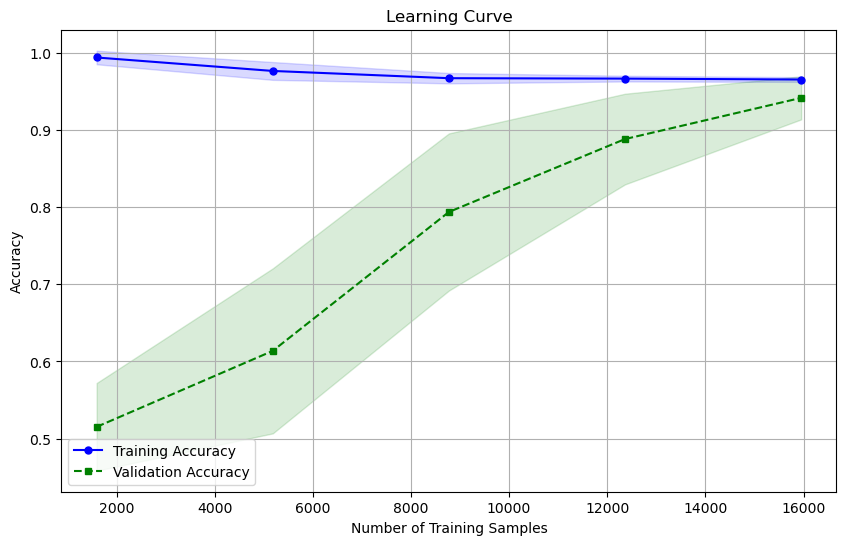

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Получение кривой обучения
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, data_all['clean_text'], labels, cv=5)

# Вычисление средних оценок
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Визуализация кривой обучения
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


C:\Users\daure\AppData\Local\Temp\ipykernel_16072\1492995348.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = results.pivot('param_tfidf__max_features', 'param_model__C', 'mean_test_score')
C:\Users\daure\AppData\Local\Temp\ipykernel_16072\1492995348.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = results.pivot('param_tfidf__max_features', 'param_model__C', 'mean_test_score')
C:\Users\daure\AppData\Local\Temp\ipykernel_16072\1492995348.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = results.pivot('param_tfidf__max_features', 'param_model__C', 'mean_test_score')


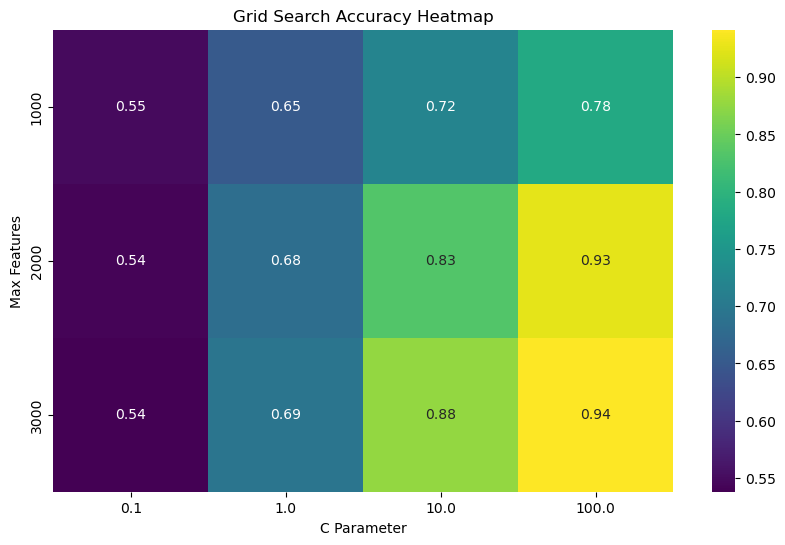

In [4]:
import seaborn as sns

# Получение результатов кросс-валидации
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot('param_tfidf__max_features', 'param_model__C', 'mean_test_score')

# Визуализация карты точности
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.xlabel('C Parameter')
plt.ylabel('Max Features')
plt.title('Grid Search Accuracy Heatmap')
plt.show()


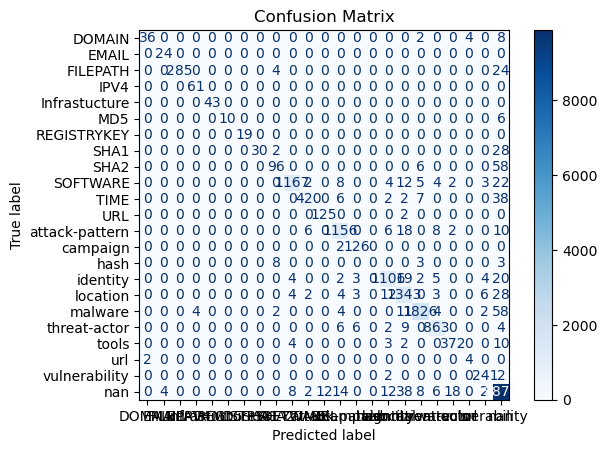

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Получение предсказаний на тестовых данных
y_pred = grid_search.predict(data_all['clean_text'])

# Вычисление матрицы ошибок
cm = confusion_matrix(labels, y_pred)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
